# CM50268 :: Lab 3 :: Gaussian Processes

**Total Marks 20 (20% of overall unit marks).**

*Start date: Monday March 16, 2020. Submission deadline: midnight, Thursday April 2, 2020.*

In this lab you will implement your own Gaussian Process model using the TensorFlow toolkit!

## Tasks

- Implement a numpy function that evaluates the squared exponential kernel using for loops and use it to check that the tensorflow function provided is correct. \[2 marks\]

- Get the GP regression code running on a toy example with a Gaussian likelihood

- Now run the code on traffic count data (the training outputs are integers) and observe what happens. Add a brief text comment highlighting what has gone wrong and why. \[2 marks\]

- Implement a periodic kernel to replace the squared exponential kernel and run the regression model with the new kernel. Does the situation improve slightly? \[6 marks\]

- Now prove two of the mathematical results in the derivation of the lower bound for a variational Gaussian Process using a Poisson likelihood (non-Gaussian likelihood). \[4 marks + 2 bonus marks\]

- Modify the original GP regression code to implement the Poisson likelihood GP and run it on the count data with the squared exponential kernel. \[4 marks\]

- Run your Poisson GP with the periodic kernel and comment on the final output. \[2 marks\]

## Important Notes - Please Read!

### Programming and TensorFlow

- Please see the separate "Introduction to TensorFlow" notebook (from Machine Learning 1) if you are not familiar with TensorFlow

### If you installed the latest TensorFlow 2.0, do the following 2 lines when import:
import tensorflow.compat.v1 as tf 

tf.disable_eager_execution()

#### TensorFlow dtype
Due to interations between the CPU and GPU, TensorFlow is quite strict about the difference between single and double precision floating point numbers (`tf.float32` and `tf.float64`) respectively. To be safe, when declaring constants and variables in TensorFlow I always specify the `dtype` parameter by using defining `dtype` and `dtype_convert` at the top of the file. This allows, for example:
```python
t_vector_of_ones = tf.ones(shape=[5], dtype=dtype)
t_correct_precision = dtype_convert(t_not_correct_precision)
```
If you get tensorflow errors about `tf.float32` and `tf.float64` you probably have a constant declared using the wrong `dtype` somewhere in the computational graph.

#### Inverting the covariance matrix
Covariance matrices should be symmetric and positive definite - this means that they can be inverted using the Cholesky decomposition $K = L L^{\mathtt{T}}$ where $L$ is a square, lower triangular matrix. There is a TensorFlow operation `t_L_matrix = tf.cholesky(t_K_matrix)` that returns the matrix $L$. 

Once you have the decomposed matrix, it is efficient to evaluation the matrix inversion $A = K^{-1} B$ using the special solve operation `t_A_matrix = tf.cholesky_solve(t_L_matrix, t_B_matrix)`. 

If you need to perform the operation $A = L^{-1} B$ there is also a special operation `t_A_matrix = tf.matrix_triangular_solve(t_L_matrix, t_B_matrix)`.

Because the cholesky decomposition requires a positive definite matrix, we often add a small "jitter" diagonal matrix to try to improve the nummerical stability (in case the eigenvalues of the kernel become close to zero). For example we would perform the following:
```python
jitter = 1.0e-8
t_L_matrix = tf.cholesky(t_K_matrix + jitter * tf.eye(tf.shape(t_K_matrix)[0], dtype=dtype)
```
where `tf.shape()[0]` is returning the size of the kernel matrix to build a diagonal matrix identity matrix using `tf.eye()` (and we note that we specify the `dtype` of the matrix).


### Markdown Cells (for written and maths answers)

- For the answers to the maths derivations you can provide your answers in LaTeX form within a cell. If you change the cell mode to "Markdown" then you can enter equations between double dollar signs:

```
You can type normal text in markdown adding inline equations $y = m x + c$ as well as full line equations

$$p(y \mid x) = \frac{p(x \mid y) p(y)}{p(x)}$$

or even aligned equations where the & sign lines up:

\begin{align}
t &= f(x) + \varepsilon\\
\varepsilon &\sim \mathcal{N}(0, \sigma^2)
\end{align}
```

- This will be converted to:

> You can type normal text in markdown adding inline equations $y = m x + c$ as well as full line equations
>
>$$
p(y \mid x) = \frac{p(x \mid y) p(y)}{p(x)}
$$
>
>or even aligned equations where the & sign lines up:
>
>\begin{align}
t &= f(x) + \varepsilon\\
\varepsilon &\sim \mathcal{N}(0, \sigma^2)
\end{align}

- If you would prefer to provide your maths answers in another form it is also acceptable to upload a PDF or write answers by hand and scan them in as a PDF


In [1]:
# Import statements..

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

dtype = tf.float64
dtype_convert = tf.to_double

np.random.seed(0)

## Squared Exponential Covariance Kernel

The following tensorflow code evaluates a squared exponential covariance in **vectorised** form (more efficient computation). It is good practice to check your tensorflow code as you write it using simple (but often inefficient) numpy code where we are less likely to introduce errors.

In [2]:
def get_lengthscale_euclid_sq_dist(t_X, t_Z, t_lengthscale):
    t_inv_lengthscale_squared = 1.0 / tf.square(t_lengthscale)
    xx = t_inv_lengthscale_squared * tf.reduce_sum(t_X * t_X, axis=1, keep_dims=True)
    zz = t_inv_lengthscale_squared * tf.reduce_sum(t_Z * t_Z, axis=1, keep_dims=True)
    return xx + tf.transpose(zz) - 2.0 * t_inv_lengthscale_squared * tf.matmul(t_X, t_Z, transpose_b=True)

def create_squared_exp_kernel(t_X1, t_X2, t_signal_variance, t_lengthscale):
    dist_x1x2_sq = get_lengthscale_euclid_sq_dist(t_X1, t_X2, t_lengthscale)
    return t_signal_variance * tf.exp(- 0.5 * dist_x1x2_sq)

###  Task 1: Implement a function that calculates the squared exponential kernel in numpy using for loops and use it to check that the TensorFlow code operates correctly. (2 marks)


In [3]:
def numpy_squared_exp_kernel(X, signal_variance, lengthscale):
    
    # Add code using for loops to generate K(X, X)
    K=[]
    for each_first_x in X:
        each_first_x=each_first_x[0]
        row_list=[]
        for each_second_x in X:
           
            each_second_x=each_second_x[0]
            power=(-1*(each_first_x-each_second_x)**2)/(2*(lengthscale**2))
            value=signal_variance*np.exp(power)
            row_list.append(value)
        K.append(np.array(row_list))
    K=np.array(K)
    return K

# Testing part:
lengthscale = 2.3
signal_variance = 1.4

N = 5
X = np.random.randn(N,1)

tf.reset_default_graph()
with tf.Session() as session:
    t_lengthscale = tf.constant(lengthscale, dtype=dtype)
    t_signal_variance = tf.constant(signal_variance, dtype=dtype)
    t_X = tf.constant(X, dtype=dtype)
    
    t_K = create_squared_exp_kernel(t_X1=t_X, 
                                    t_X2=t_X, 
                                    t_signal_variance=t_signal_variance,
                                    t_lengthscale=t_lengthscale)
    
    print('TensorFlow K =\n', session.run(t_K))
    
    numpy_K = numpy_squared_exp_kernel(X=X, 
                                      signal_variance=signal_variance, 
                                      lengthscale=lengthscale)
    
    print('My numpy checking code K = \n', numpy_K)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
TensorFlow K =
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]
My numpy checking code K = 
 [[1.4        1.17427272 1.32072556 1.37023329 1.39858306]
 [1.17427272 1.4        1.35639685 1.01634838 1.14219291]
 [1.32072556 1.35639685 1.4        1.20430393 1.2992705 ]
 [1.37023329 1.01634838 1.20430393 1.4        1.38167758]
 [1.39858306 1.14219291 1.2992705  1.38167758 1.4       ]]


## GP Regression Model

The following is TensorFlow code that implements a regression GP model with a Gaussian likelihood (as per the lecture notes). Look through to see how the function works and correlate the code with the mathematical expressions for the marginal log likelihood and the predictive posterior code. Note that we optimise the **negative log likelihood** in TensorFlow since the optimiser **minimises** the objective function.

In [4]:
# A wrapper function to create a real number variable (-infinity, infinity)
# with an initial value that will be optimised by tensorflow.
def create_real_variable(initial_value):
    return tf.Variable(initial_value, dtype=dtype)

# A wrapper function to create a positive variable (0, infinity) by
# taking the exp() of a real number - this will map the real range to
# the set of positive numbers.
def create_positive_variable(initial_value):
    assert initial_value > 0.0
    return tf.exp(tf.Variable(np.log(initial_value), dtype=dtype))

# A Gaussian Process class to keep all the parts of the model we need
# grouped together
class GP:
    def __init__(self,
                 description,
                 t_objective,
                 create_prediction_function,
                 t_prediction_placeholder,
                 t_prediction_mean,
                 t_prediction_var,
                 t_input=None,
                 t_output=None,
                 hyperparameter_dict={}):

        self._description = description
        self._t_objective = t_objective
        self._create_prediction_function = create_prediction_function
        self._t_prediction_placeholder = t_prediction_placeholder
        self._t_prediction_mean = t_prediction_mean
        self._t_prediction_var = t_prediction_var
        self._t_input = t_input
        self._t_output = t_output
        self._hyperparameter_dict = hyperparameter_dict

    @property
    def description(self): return self._description

    @property
    def t_objective(self): return self._t_objective

    @property
    def t_prediction_placeholder(self): return self._t_prediction_placeholder

    @property
    def t_prediction_mean(self): return self._t_prediction_mean

    @property
    def t_prediction_var(self): return self._t_prediction_var

    @property
    def t_input(self): return self._t_input

    @property
    def t_output(self): return self._t_output

    @property
    def hyperparameter_dict(self): return self._hyperparameter_dict

    def create_prediction(self, tf_input):
        return self._create_prediction_function(tf_input)
    

# Create a GP regression model by specifying the input and output data, as (N x 1) matrices,
# and the initial values for the hyperparameters (these will be turned into tensorflow variables
# and optimised).
def create_gp(input_data, 
              output_data, 
              initial_signal_variance,
              initial_lengthscale,
              initial_sigma_noise_sq):

    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    t_lengthscale = create_positive_variable(initial_lengthscale)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'lengthscale': t_lengthscale,
                           'sigma_noise_squared': t_sigma_noise_sq}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
    kernel_creation_function = lambda t_X1, t_X2: \
        create_squared_exp_kernel(t_X1=t_X1, 
                                  t_X2=t_X2,
                                  t_lengthscale=t_lengthscale,
                                  t_signal_variance=t_signal_variance)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    t_L_xx = tf.cholesky(t_K_xx)

    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(t_lengthscale)) 

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp


# Print out the current values of the hyperparameters
def print_hyperparameters(gp, session):
    for (k, v) in gp.hyperparameter_dict.items():
        print('{} = {:.6}'.format(k, session.run(v)))
    print('')


# Plot the predicitve posterior for the provide input values (num_test_points x 1 matrix) 
def plot_gp_predictions(gp, session, input_values):
    # Ensure N* x 1 input variable
    if input_values.ndim == 1:
        input_values = input_values[:,np.newaxis]
    
    feed_dict = {gp.t_prediction_placeholder: input_values}
    
    pred_mean, pred_var = session.run((gp.t_prediction_mean, 
                                       gp.t_prediction_var), 
                                      feed_dict=feed_dict)
    
    plt.figure(figsize=[12,6])
    plt.plot(session.run(gp.t_input), session.run(gp.t_output), 'k.')
    plt.plot(input_values, pred_mean, 'r-')
    plt.plot(input_values, pred_mean + 2.0 * np.sqrt(pred_var), 'r:')
    plt.plot(input_values, pred_mean - 2.0 * np.sqrt(pred_var), 'r:')
    plt.grid(True)

    
    

###  Task 1a: Run the GP model on the following toy dataset to ensure everything is working.

Instructions for updating:
Use `tf.cast` instead.
Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 24.26587549185136
  opt iter   200: objective = 6.282378000976836
  opt iter   400: objective = 6.282377976574926
  opt iter   600: objective = 6.282377976574853
  opt iter   800: objective = 6.282377976574875
  opt iter  1000: objective = 6.282377976574983
  opt iter  1200: objective = 6.2823798272542195
  opt iter  1400: objective = 6.282377976574908
  opt iter  1600: objective = 6.287930405639074
  opt iter  1800: objective = 6.282377976574894
Final iter  1999: objective = 6.28237797666495

After Optimisation:
signal_variance = 0.958691
lengthscale = 0.590213
sigma_noise_squared = 0.0145719



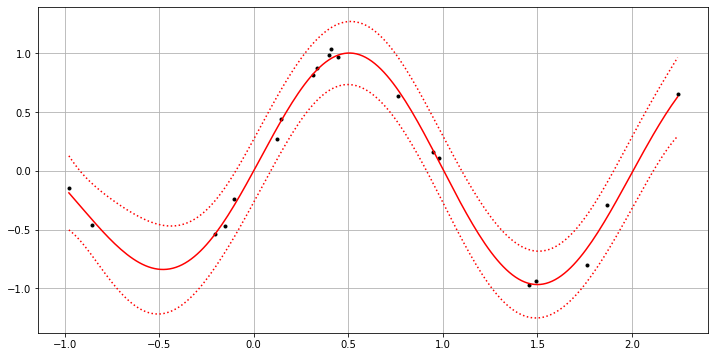

In [5]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = np.random.randn(N,1)
output_data = np.sin(np.pi * input_data) + 0.05 * np.random.randn(N,1)

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



## Bike Traffic Count Dataset

The following data is take from the UK Department of Transport figures counting how many cyclists crossed Vauxhall Bridge over Monday to Friday (week starting 31st July 2008). We note that the counts per hour are integers.

C:\Users\Tisana\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,31,70,186,351,194,65,23,30,29,22,31,34,59,68,41,23,14,5,4
1,40,64,203,406,201,59,26,32,36,23,31,39,66,73,52,27,15,11,4
2,29,62,194,347,168,58,35,41,31,29,37,39,70,76,30,16,13,12,8
3,35,55,155,318,166,51,43,34,40,21,25,34,52,59,31,21,8,13,5
4,33,44,121,243,139,48,35,44,34,37,27,35,44,52,27,21,16,10,7


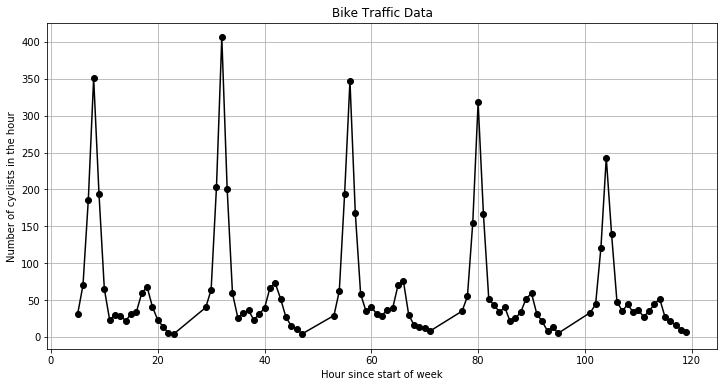

In [6]:
bike_data = pd.read_csv('traffic_data_week_2008_07_31.csv')
bike_data = bike_data.drop([5,6])
counts = bike_data.as_matrix().flatten()
times = np.zeros(bike_data.shape)
for n, r in bike_data.iterrows():
    times[n,:] = bike_data.columns.astype(np.float64) + (n*24)
times = times.flatten()

bike_counts = counts[:,np.newaxis]
bike_times = times[:,np.newaxis]

plt.figure(figsize=[12,6])
plt.plot(bike_times, bike_counts, 'ko-')
plt.grid(True)
plt.title('Bike Traffic Data')
plt.xlabel('Hour since start of week')
plt.ylabel('Number of cyclists in the hour')

bike_data

###  Task 2: Run the GP code with a squared exponential kernel on the bike count data. In the box below, comment on the result - how did the Gaussian GP model do? (2 marks)

Before Optimisation:
signal_variance = 1.0
lengthscale = 1.0
sigma_noise_squared = 1.0

  opt iter     0: objective = 170865.72843773948
  opt iter   200: objective = 1974.7006453601068
  opt iter   400: objective = 1002.7616672497584
  opt iter   600: objective = 769.0917894566404
  opt iter   800: objective = 687.3504092835047
  opt iter  1000: objective = 653.8017301622671
  opt iter  1200: objective = 638.914947072982
  opt iter  1400: objective = 632.0909944106791
  opt iter  1600: objective = 628.9576378086272
  opt iter  1800: objective = 627.5484481436597
Final iter  1999: objective = 626.9384260486809

After Optimisation:
signal_variance = 162.428
lengthscale = 4.22954
sigma_noise_squared = 6687.03



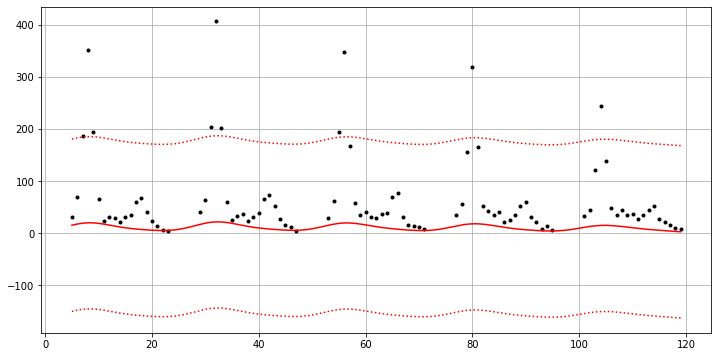

In [7]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_gp(input_data=input_data, 
               output_data=output_data, 
               initial_signal_variance=1.0,
               initial_lengthscale=1.0,
               initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



###  **Type comment in box below:**
the model under fit


## Switch to using periodic kernel

###  Task 3: Implement the periodic kernel (2 marks) and copy and paste the GP code from above, modifying it to use your new periodic kernel and verify the results by running the code with pre-defined settings (4 marks, you will have to add a new positive parameter to represent the period $T$). (6 marks in total)

**The periodic kernel is defined as:**

$$
K(x_i, x_j) = \sigma_{\mathrm{f}}^{2} \exp\!\left( - 2 \gamma \left[\sin\left(\frac{\pi}{T} \sqrt{\|x_i - x_j\|^2} \right)\right]^2 \right)
$$

**Hyperparameters:**
- Signal variance $\sigma_{\mathrm{f}}^2$ (positive)
- Inverse Lengthscale $\gamma = 1 / \ell^2$ (positive)
- Period $T$ (positive)

In [8]:
def create_periodic_kernel(t_X1, t_X2, t_signal_variance, t_gamma, t_period):
    # Add code to this function..
    dist_sq=get_lengthscale_euclid_sq_dist(t_X1, t_X2, tf.sqrt(1/t_gamma))
    pi = tf.constant(np.pi,dtype=tf.float64)
    inside=pi*tf.sqrt(dist_sq)/t_period
    power=-2*t_gamma*((tf.math.sin(inside))**2)
    
    k=t_signal_variance*tf.exp(power)

    return k
 

# Modify this function as appropriate..
def create_periodic_gp(input_data, 
                       output_data, 
                       initial_signal_variance,
                       initial_gamma,
                       initial_period,
                       initial_sigma_noise_sq):
 
    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.shape(t_Y)[0]
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    #t_lengthscale = create_positive_variable(1.0)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    t_gamma = create_positive_variable(initial_gamma)
    t_period=create_positive_variable(initial_period)
    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'gamma': t_gamma,
                           'sigma_noise_squared': t_sigma_noise_sq,
                           'period':t_period}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
        
    kernel_creation_function = lambda t_X1, t_X2: \
        create_periodic_kernel(t_X1=t_X1, 
                               t_X2=t_X2, 
                               t_signal_variance=t_signal_variance, 
                               t_gamma=t_gamma, 
                               t_period=t_period)
    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)

    # Take the cholesky decomposition of K = L L^T to make it easy to calculate 
    # the inverse of K and the log determinant of K. This relies on K being a 
    # positive definite covariance matrix.
    
    t_L_xx = tf.cholesky(t_K_xx)


    # The log determinant of K is twice the sum of the log of the diagonal of the
    # cholesky matrix
    t_log_det = 2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))

    # We can calculate the data fit term by using the cholesky matrix L to
    # invert the covariance matrix efficiently using the matrix triangular solve
    # operation. 
    #
    # Tr[K^-1 Y Y^T] = Tr[Y^T (L L^T)^-1 Y] = Tr[(Y^T L^-T) (L^-1 Y)] = sum((L^-1 Y)^2)
    #
    t_Kinv_YYtranspose = 0.5 * tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, t_Y, lower=True)))

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(tf.sqrt(1/t_gamma)))

    half_log_two_pi = tf.constant(0.5 * np.log(2.0 * np.pi), dtype=dtype)

    # Evaluate the NEGATIVE (since we will minimise) marginal log likelihood as
    # the objective for training the hyperparameters
    t_neg_log_likelihood = half_log_two_pi * dtype_convert(t_D) * dtype_convert(t_N) \
                         + 0.5 * dtype_convert(t_D) * t_log_det \
                         + t_Kinv_YYtranspose + t_hyper_prior + t_noise_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_Y)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return t_y_mean, t_y_var

    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Gaussian Process',
            t_objective=t_neg_log_likelihood,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp

### Task 3a *Run the code below after writing the functions above..*

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Before Optimisation:
signal_variance = 1.0
gamma = 1.0
sigma_noise_squared = 1.0
period = 24.0

  opt iter     0: objective = 136405.73566419663
  opt iter   200: objective = 1950.9146561865464
  opt iter   400: objective = 1010.5237288332711
  opt iter   600: objective = 756.4772164274325
  opt iter   800: objective = 653.862782180613
  opt iter  1000: objective = 604.5657898641311
  opt iter  1200: objective = 578.6820891508464
  opt iter  1400: objective = 564.3453958222235
  opt iter  1600: objective = 556.0563879402359
  opt iter  1800: objective = 551.0241479540043
Final iter  1999: objective = 547.7644645743443

After Optimisation:
signal_variance = 25020.3
gamma = 2.15738
sigma_noise_squared = 408.073
period = 35.258



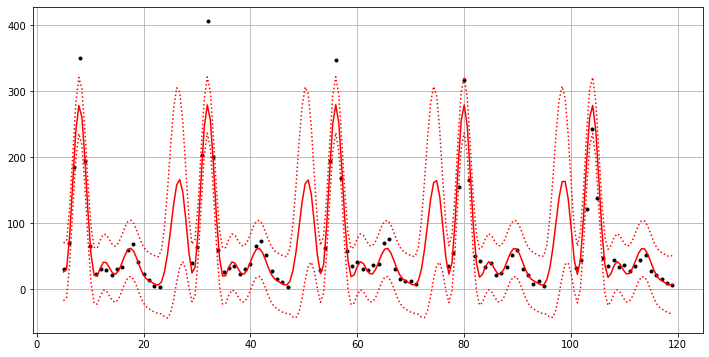

In [9]:
tf.reset_default_graph()

N = 20

np.random.seed(0)

input_data = bike_times
output_data = bike_counts

gp = create_periodic_gp(input_data=input_data, 
                        output_data=output_data, 
                        initial_signal_variance=1.0,
                        initial_gamma=1.0,
                        initial_period=24.0,
                        initial_sigma_noise_sq=1.0)

with tf.Session() as session:
    feed_dict = {}

    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)

## Gaussian Process Regression with Poisson Likelihood

The Poisson distribution is a probability distribution over counts within a fixed time period (positive integer values). The likelihood function is defined in terms of a positive rate parameter $\lambda > 0$ as

$$
p(y) = \frac{\lambda^{y} \exp(-\lambda)}{y!}, \; y \in [0,1,2,3,\dots]
$$

In a similar manner to the GP for binary classification (Bernoulli likelihood), we can define a GP with a Poisson likelihood

$$
p(Y, f \mid X, \theta) = p(Y \mid f) \, p(f \mid X, \theta)
$$

where the $\lambda$ parameter in the Poisson likelihood is a function of $f$. Assuming iid data we have

$$
p(Y \mid X) = \prod_{n=1}^{N} \frac{{\lambda(f_n)}^{y_n} \exp(-\lambda(f_n))}{y_n!}
$$

We put a GP prior over $f$

$$
p(f \mid X, \theta) = \mathcal{N}(f \mid 0, \kappa(X,X;\theta))
$$

however this makes the value of $f$ a real number. We map this to a positive number through the exponential function such that

$$
\lambda(f_n) = \exp(f_n) \; \Rightarrow \; \lambda(f_n) \in \mathcal{R}^{+} 
$$

To calculate the marginal log likelihood we must integrate out the function parameters $f$ such that

$$
\log p(Y \mid X, \theta) = \log \int p(Y \mid f) \, p(f \mid X, \theta) \mathrm{d}f
$$

As for the classification GP, we cannot perform this operation in closed form so we use an variational approximation 

$$
q(f) = \prod_n \mathcal{N}(f_n \mid \mu_n, \sigma^2)
$$

with a mean parameter $\mu_n$ for each $f_n$ and a shared variance $\sigma^2$.

The variational lower bound can then be defined as 

$$
\mathcal{L} =  \sum_n \mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] - \mathrm{KL}\big[ q(f) \,\|\, p(f\mid X, \theta) \big]
$$

We now look at the two terms in the lower bound and the next task is to derive expressions related to the expectation and the KL divergence.


### Task 4a Find an expression for the KL divergence between two **univariate** Gaussian distributions (2 marks) :
    
$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \sigma_0^2) \| \mathcal{N}(x \mid \mu_1, \sigma_1^2) \right] =
\int \mathcal{N}(x \mid \mu_0, \sigma_0^2) \log \frac{\mathcal{N}(x \mid \mu_0, \sigma_0^2)}{\mathcal{N}(x \mid \mu_1, \sigma_1^2)} \mathrm{d}x
$$

Hint: 
The integral of a standardised Gaussian distribution:
$$
 \int \mathcal{N}(x \mid \mu, \sigma^2)\mathrm{d}x  = 1
$$
But the integral in the following form needs to be derived using your basic calculus knowledge
$$
\int x \mathcal{N}(x \mid \mu, \sigma^2)  \mathrm{d}x
$$

The expression after derivation should only contain known parameters such as $\mu_0$, $\mu_1$, $\sigma_0$, $\sigma_1$.




####  **Enter the derivation procedure in this Markdown box..** 


Let:

p(x) = N(mu0,var0)

q(x) = N(mu1,var1)




∫ p(x) log(p(x)/q(x)) dx



=∫ [log(p(x)) - log(q(x))]dx



= ∫ [-0.5log(2pi) -log(sigma0) -0.5((x-mu0)/sigma0)^2) +0.5log(2pi) +log(sigma1) +0.5((x-mu1)/sigma1)^2 ] * 1/sqrt(2pivar0) *exp(-0.5((x-mu0)/sigma0)^2dx



=E0[log(sigma1/sigma0) +0.5[((x-mu1)/sigma1)^2 + ((x-mu0)/sigma0)^2]]



=log (sigma1/sigma0) + (1/(2*var1))E0[(x-mu1)^2] -0.5


=log (sigma1/sigma0) + (var0^2+(mu0-mu1)^2)/(2*var1^2) -0.5

The corresponding KL divergence for **multivariate** Gaussians is given by

$$
\mathrm{KL}\left[\mathcal{N}(x \mid \mu_0, \Sigma_0) \| \mathcal{N}(x \mid \mu_1, \Sigma_1) \right] = 
\frac{1}{2} \left( \mathrm{Tr}[\Sigma_1^{-1} \Sigma_0] + (\mu_1 - \mu_0)^{T}\Sigma_1^{-1}(\mu_1 - \mu_0) - N + \log \frac{\det \Sigma_1}{\det \Sigma_0} \right), \;\text{for}\; x \in \mathbb{R}^{N}
$$

### Task 4b  Prove the following expression is the KL divergence between the approximating distrbution and our Gaussian process prior on $f$ (2 marks)

$$
\mathrm{KL}\left[ q(f) \| p(f\mid X, \theta) \right] = \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right), \; K = \kappa(X,X;\theta)
$$




####  **Enter the derivation procedure in this Markdown box..** 


k(q,p)=0.5*(Tr[K^-1 sigma^2 I]+(0-mu)^T K^-1 (0-mu) -N +log(detK/detsigma^2I))

=0.5*(Tr[K^-1 sigma^2 I]+K^-1*mu*mu^T -N +log detK -log det sigma^2 I)

=0.5*(Tr[K^-1 (sigma^2 I + mu*mu^T)] -N +log detK -N log sigma^2)


The expectation expression can be decomposed into a sum over each $f_n \sim \mathcal{N}(\mu_n, \sigma^2)$. 

### Task 4c (Bonus task) Prove that the following expression is the expectation of the log likelihood of the Poisson distribution wrt $q(f_n)$ (2 marks)

$$
\mathbb{E}_{q(f_n)}\!\left[ \log p(y_n \mid f_n) \right] = y_n \mu_n - \exp\left( \frac{2\mu_n + \sigma^2}{2} \right) - \log(y_n!)
$$

Note: for the lower bound we can ignore the $\log(y_n!)$ term since it is constant wrt the hyperparameters and variational parameters.





####  **Enter the derivation procedure in this Markdown box..** 


fn follow normal (mu,variance)


loglikelihood = log [lambda(fn)^yn * exp(-lambda(fn)) * 1/yn!]

=yn log [lambda(fn)] -lambda(fn) log(e) -log(yn!)

since lambda(yn)=exp(fn)

=ynfn - exp(fn) -log(yn!)

since MGF(t=1 is expectation) is exp(mu+(variance/2))

expectation of log likelihood = yn*mu - exp(mu+variance/2) -log(yn!)


## The Lower Bound for the Poisson GP

The final lower bound for the Poisson GP is therefore given by

$$
\mathcal{L} =  \sum_n \left\{ y_n \mu_n - \exp\left( \frac{2\mu_n + \sigma_n^2}{2} \right) - \log(y_n!) \right\} 
- \frac{1}{2} \left( \mathrm{Tr}[K^{-1}(\sigma^2 I + \mu \mu^T)] - N + \log \det K - N \log{\sigma^2} \right)
$$

### Task 5a: Update the GP code from above to optimise the negative lower bound of the Poisson GP (4 marks)

You will have to introduce extra TensorFlow variables for the variational parameters $\{\mu_n\}$ and $\sigma^2$. You can **initialise** the means as $\mu_n = \log(y_n)$ and the variance $\sigma^2 = 1$ (remember they are variables and not constants).

**IMPORTANT: You will also need to update the predictive posterior using the approach described in the lecture. For the purposes of plotting the result it is sufficent to evaluate the mean of $f^{*}$ and plot $\lambda(\mu_f^{*}) = \exp(\mu_{f}^{*})$ against the training data since $\lambda$ is the mean of a Poisson distribution.**


Before Optimisation:
signal_variance = 1.0
gamma = 1.0
sigma_noise_squared = 1.0
period = 24.0

  opt iter     0: objective = 36048.80704565696
  opt iter   200: objective = 7285.81184034067
  opt iter   400: objective = 7631.07326672986
  opt iter   600: objective = 3052.091231763937
  opt iter   800: objective = 6635.032434425662
  opt iter  1000: objective = 6003.4849231636
  opt iter  1200: objective = 2690.497417422323
  opt iter  1400: objective = 11066.214017863125
  opt iter  1600: objective = 2249.6689873477653
  opt iter  1800: objective = 6378.749426339506
Final iter  1999: objective = 3333.008194968702

After Optimisation:
signal_variance = 22073.2
gamma = 1.05322
sigma_noise_squared = 0.701346
period = 24.9127



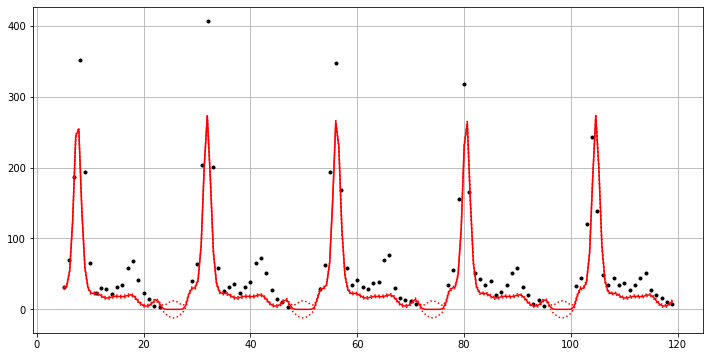

In [10]:
# Copy and paste GP code from above and modify it to make a Poisson GP.
# Run the Poisson GP with a periodic kernel and comment on the output.
def create_periodic_gp(input_data, 
                       output_data, 
                       initial_signal_variance,
                       initial_gamma,
                       initial_period,
                       initial_sigma_noise_sq,
                       initial_mu_n,
                       initial_variance):
 
    # Constant training data in tensorflow
    t_X = tf.constant(input_data, dtype=dtype)
    t_Y = tf.constant(output_data, dtype=dtype)

    t_N = tf.constant(np.shape(input_data)[0],dtype=dtype)
    t_D = tf.shape(t_Y)[1]
    t_Q = tf.shape(t_X)[1]
    jitter = 1.0e-8

    # Create variables for hyperparamers
    t_signal_variance = create_positive_variable(initial_signal_variance)
    #t_lengthscale = create_positive_variable(1.0)
    t_sigma_noise_sq = create_positive_variable(initial_sigma_noise_sq)
    t_gamma = create_positive_variable(initial_gamma)
    t_period=create_positive_variable(initial_period)
    
    t_mu_n=tf.exp(tf.Variable(np.log(initial_mu_n), dtype=dtype))
    

    t_variance=create_positive_variable(initial_variance)
  
    t_f=tf.random.normal(shape=t_mu_n.shape,mean=t_mu_n, stddev=tf.sqrt(t_variance),dtype=tf.dtypes.float64)
    

    hyperparameter_dict = {'signal_variance': t_signal_variance,
                           'gamma': t_gamma,
                           'sigma_noise_squared': t_sigma_noise_sq,
                           'period':t_period}
    
    # Create a lambda function to ensure we use the same hyperparameters
    # when be create the different kernels..
        
    kernel_creation_function = lambda t_X1, t_X2: \
        create_periodic_kernel(t_X1=t_X1, 
                               t_X2=t_X2, 
                               t_signal_variance=t_signal_variance, 
                               t_gamma=t_gamma, 
                               t_period=t_period)

    # Create the training data covariance matrix + noise identity matrix
    #
    # NOTE: We include the jitter term to improve nummerical stability
    #
    t_K_xx = kernel_creation_function(t_X1=t_X, t_X2=t_X) \
        + (t_sigma_noise_sq + jitter) * tf.eye(t_N, dtype=dtype)
    
    t_L_xx = tf.cholesky(t_K_xx)
    
    
    c1=t_variance*tf.eye(initial_mu_n.shape[0],dtype=dtype)
    c2=tf.matmul(t_mu_n,tf.transpose(t_mu_n))
    c=c1+c2
    a=tf.reduce_sum(tf.square(
        tf.matrix_triangular_solve(t_L_xx, c, lower=True)))
    
    b=2.0 * tf.reduce_sum(tf.log(tf.diag_part(t_L_xx)))
    d=t_N* tf.log(t_variance)
    e=tf.math.lgamma(t_Y+1)
    
    f=tf.exp(((2*t_mu_n)+t_sigma_noise_sq)/2)
    g=t_Y*t_mu_n
    
    first_term=tf.reduce_sum(g-f-e)
    
    second_term=0.5*(a-t_N+b-d)

    # Add a loose prior on the noise variance
    t_noise_prior = + 0.5 * tf.square(tf.log(t_sigma_noise_sq))
    
    # Add loose priors on the kernel hyperparameters
    t_hyper_prior = + 0.5 * tf.square(tf.log(t_signal_variance)) \
                    + 0.5 * tf.square(tf.log(tf.sqrt(1/t_gamma))) \
                    + 0.5 * tf.square(tf.log(t_variance) )
                    
                    
    lower_bound=first_term-second_term
    neg_lower_bound=-1*lower_bound
    
    neg_lower_bound+=t_noise_prior+t_hyper_prior

    def create_prediction(tf_input):
        # Invert using the cholesky decomposition of the kernel
        t_Kinv_Y = tf.cholesky_solve(t_L_xx, t_f)
        
        # Calculate the kernel from the input to the training data
        t_K_x_X = kernel_creation_function(t_X1=tf_input, t_X2=t_X)
        
        # Get the predicitive mean
        t_y_mean = tf.matmul(t_K_x_X, t_Kinv_Y)
        
        t_K_x_x_diag = tf.diag_part(kernel_creation_function(t_X1=tf_input, t_X2=tf_input)) \
            + t_sigma_noise_sq * tf.ones([tf.shape(tf_input)[0]], dtype=dtype)

        # Get the predicitve variance
        t_y_var = t_K_x_x_diag - tf.reduce_sum(tf.square(
            tf.matrix_triangular_solve(t_L_xx, tf.transpose(t_K_x_X))), axis=0)
        
        # Make sure a N* x 1 matrix (where N* = number of test inputs)
        t_y_var = t_y_var[:, tf.newaxis]

        # Return the predicitve mean and variance
        return tf.exp(t_y_mean), t_y_var
    
    # A placeholder for providing different test data after training. See the introduction
    # to tensorflow for details on how the placeholders work
    t_prediction_placeholder = tf.placeholder(dtype=dtype)
    t_prediction_mean, t_prediction_var = create_prediction(t_prediction_placeholder)

    gp = GP(description='Gaussian Process',
            t_objective=neg_lower_bound,
            create_prediction_function=create_prediction,
            t_prediction_placeholder=t_prediction_placeholder,
            t_prediction_mean=t_prediction_mean,
            t_prediction_var=t_prediction_var,
            t_input=t_X,
            t_output=t_Y,
            hyperparameter_dict=hyperparameter_dict)

    return gp


N = 20
tf.reset_default_graph()
np.random.seed(0)

input_data = bike_times
output_data = bike_counts
#input_data = np.random.randn(N,1)
#output_data = np.sin(np.pi * input_data) + 0.05 * np.random.randn(N,1)

gp = create_periodic_gp(input_data=input_data, 
                        output_data=output_data, 
                        initial_signal_variance=1.0,
                        initial_gamma=1.0,
                        initial_period=24.0,
                        initial_sigma_noise_sq=1.0,
                        initial_mu_n=np.log(output_data),
                        initial_variance=1.0)


with tf.Session() as session:
    feed_dict = {}
    t_objective = gp.t_objective
    learning_rate = 0.1
    num_iterations = 2000

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(t_objective)
    
    session.run(tf.global_variables_initializer())
    
    print('Before Optimisation:')
    print_hyperparameters(gp, session)

    refresh_iter = int(np.ceil(num_iterations / 10))
    for i in range(num_iterations):
        opt, cost = session.run((optimizer, t_objective),
                                feed_dict=feed_dict)
        if (i % refresh_iter) == 0:
            print('  opt iter {:5}: objective = {}'.format(i, cost))

    print('Final iter {:5}: objective = {}\n'.format(i, cost))
    
    print('After Optimisation:')
    print_hyperparameters(gp, session)
    
    input_values = np.linspace(np.min(input_data), np.max(input_data), 200)
    plot_gp_predictions(gp, session, input_values)



### Task 5b: Write comments in the Markdown box below.. (2 marks)

The model fit quite well to the original bike traffic data

